In [1]:
import numpy as np
import os
import pandas as pd
import PIL
import PIL.Image
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import cv2

from keras.models import Sequential, Model
from keras.layers import Input, merge, Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.callbacks import CSVLogger, ModelCheckpoint

0it [00:00, ?it/s]
Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def shorten(df):
    collist = [col for col in df.columns if col not in ['img']]
    return df[collist]

def explode_df(data_df):
    exploded_df = []
    
    for col in ['center','left','right']:
        partial_df = data_df[[col] + ['steering','throttle','speed']]
        
        partial_df=partial_df.rename(columns = {col:'img_path'})
        
        exploded_df.append(partial_df)
        
    exploded_df = pd.concat(exploded_df)
    return exploded_df

def change_col_path(data_df, col_name):
    data_df.loc[:,col_name] = data_df.loc[:,col_name].apply(lambda name: data_path + "IMG/" + os.path.basename(name))
    return data_df

def read_imgs(data_df):
    data_df.loc[:,'img'] = data_df.loc[:,'img_path'].progress_apply(lambda path: read_image(path))
    return data_df

def read_df(csv_path, nr_elems = None):
    data_df = pd.read_csv(csv_path,  names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    
    if(nr_elems != None):
        data_df = data_df.iloc[:nr_elems]
        
    data_df = explode_df(data_df)    
    data_df = change_col_path(data_df, 'img_path')
    
    data_df = read_imgs(data_df)
    
    data_df = data_df.set_index('img_path')
    
    data_df = shuffle(data_df, random_state = 0)
    return data_df

def plot_imgs(data_df,nr_imgs):
    
    for _,row in  data_df.iloc[:nr_imgs].iterrows():
    
        plt.imshow(row['img'])
        plt.figure()
    
        plt.show()

        
def crop(image):
    return image[60:-25, :, :]

def read_image(path):
    img = PIL.Image.open(path)
    img = np.asarray(img)
    img = crop(img)
    
    return img

def split_train_test(data_df, train_percentage):
    
    nr_train = int(train_percentage * len(data_df))
    train_df = data_df[:nr_train]
    test_df = data_df[nr_train:]
    
    return train_df, test_df


def get_formated_data(data_df):
    imgs = np.stack(data_df['img'].tolist())
    labels = np.stack(data_df['steering'].tolist())
    
    imgs = np.transpose(imgs,(0,3,1,2))
    return imgs, labels

def get_flipped_df(data_df):
    
    augmented_df = data_df.copy()
    
    augmented_df.loc[:,'img'] = augmented_df.loc[:,'img'].apply(lambda img: cv2.flip(img, 1))
    augmented_df.loc[:,'steering'] = augmented_df.loc[:,'steering'].apply(lambda steering: -steering)
    
    return augmented_df


In [3]:
data_path = "../datasets/self-driving-car/data/"
img_path = data_path + "IMG/"
csv_path = data_path + "driving_log.csv"

img_size = (75, 320)

In [4]:
data_df = read_df(csv_path)
data_df.shape

13680it [00:29, 462.19it/s] 


(13680, 4)

In [5]:
shorten(data_df).head()

,steering,throttle,speed
img_path,,,
../datasets/self-driving-car/data/IMG/left_2017_09_30_21_53_41_295.jpg,0.0,1,30.19016
../datasets/self-driving-car/data/IMG/right_2017_09_30_21_53_32_294.jpg,-0.2,1,30.18088
../datasets/self-driving-car/data/IMG/right_2017_09_30_21_52_23_992.jpg,0.0,1,30.19005
../datasets/self-driving-car/data/IMG/right_2017_09_30_21_52_43_149.jpg,0.0,1,30.19026
../datasets/self-driving-car/data/IMG/center_2017_09_30_21_51_20_217.jpg,0.0,1,30.19031


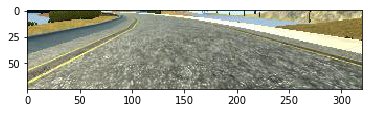

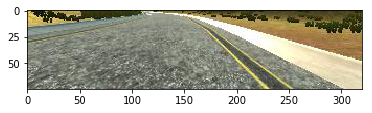

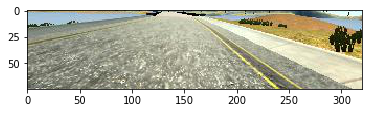

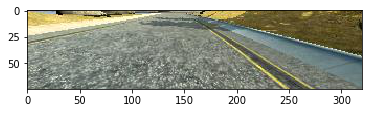

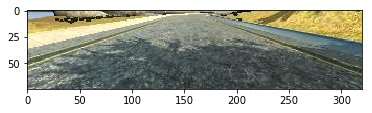

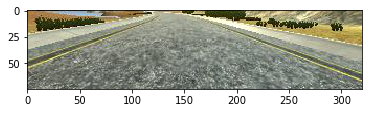

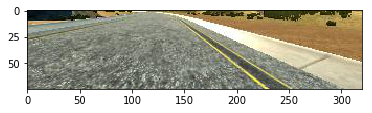

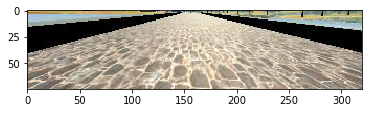

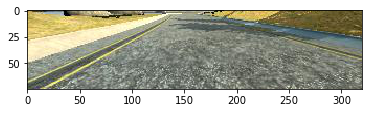

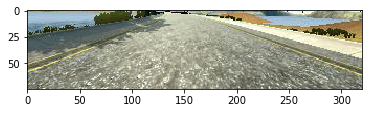

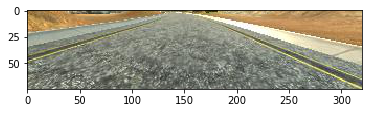

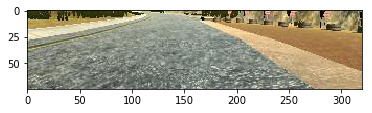

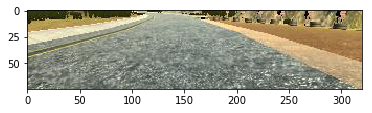

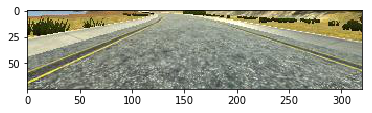

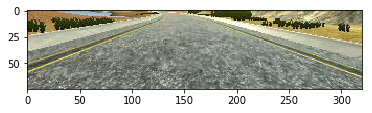

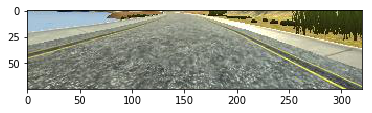

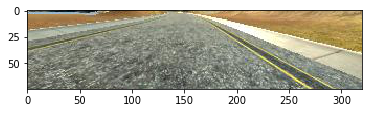

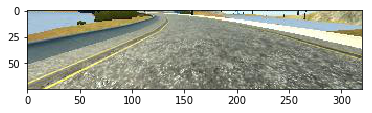

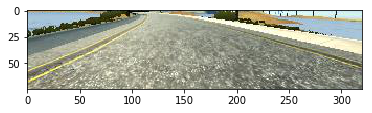

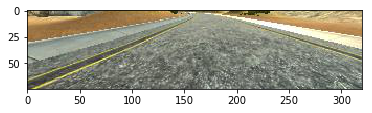

In [6]:
plot_imgs(data_df,nr_imgs = 20)

In [7]:
augmented_df = get_flipped_df(data_df)
data_df = pd.concat([data_df,augmented_df])
data_df = shuffle(data_df,random_state = 0)
data_df.shape

(27360, 4)

In [8]:
train_df, test_df = split_train_test(data_df, train_percentage = 0.8)

In [9]:
print(train_df.shape)
print(test_df.shape)

(21888, 4)
(5472, 4)


In [10]:
train_imgs, train_labels = get_formated_data(train_df)
test_imgs, test_labels = get_formated_data(test_df)

In [11]:
print(train_imgs.shape)
print(train_labels.shape)

print(test_imgs.shape)
print(test_labels.shape)

(21888, 3, 75, 320)
(21888,)
(5472, 3, 75, 320)
(5472,)


# Model

In [12]:
def get_model():
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(3,) + img_size, output_shape = (3,) + img_size))
    model.add(Convolution2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(BatchNormalization(axis=1))
    
    model.add(Convolution2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(BatchNormalization(axis=1))
    
    model.add(Convolution2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(BatchNormalization(axis=1))
    
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
    
    return model

In [13]:
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 75, 320)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 24, 36, 158)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 24, 36, 158)   96          convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 36, 16, 77)    21636       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [ ]:
model.fit(train_imgs, train_labels,
      nb_epoch= 50,               
      validation_data = (test_imgs, test_labels),
      callbacks = [CSVLogger("./training.txt"), \
                  ModelCheckpoint("./model_temp.h5", monitor='val_loss', verbose= 1, save_best_only=True, mode='min')
                 ]
      )

In [ ]:
# model.save_weights("./first.h5")